In [1]:
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import time

In [2]:
# read excel file using variable sheet_name to access the sheet i want 
file_path = "C:\\Users\\pc\\Downloads\\studentcourses (edited).xlsx"

# Get all sheet names
xl = pd.ExcelFile(file_path)
sheet_names = xl.sheet_names
print("Available sheets in the Excel file:")
for i, name in enumerate(sheet_names, 1): # enumerate used to get the index and the value from list together
    print(f"{i}. {name}")
    
sheet_name = sheet_names[4]  # Using the sheet i want to use in the list 
print(f"\nUsing sheet: '{sheet_name}'")

df = pd.read_excel(file_path, sheet_name=sheet_name)

Available sheets in the Excel file:
1. علوم طبية 
2. صيدلة وطب اسنان
3. العلوم الادارية
4. الهندسة
5. حاسب الي

Using sheet: 'حاسب الي'


In [3]:
# Keep only StudentID, CourseName, and CRN
df_clean = df.iloc[:, [0, 2, 6]]
df_clean.columns = ["StudentID", "CourseName", "CRN"]
df_clean.dropna(inplace=True)

C:\Users\pc\AppData\Local\Temp\ipykernel_9700\4046373133.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dropna(inplace=True)


In [4]:
# Build the conflict graph
G = nx.Graph()

In [5]:
# Group courses by student
student_courses = df_clean.groupby("StudentID")["CRN"].apply(list)

print(student_courses)

StudentID
1101321002                    [113114, 113107, 113121, 211430]
1301311010    [115252, 111238, 111304, 115224, 115181, 114203]
1305322014            [115174, 111121, 115171, 114182, 114191]
1305331021            [113114, 113134, 113107, 113127, 211430]
1401301022            [215189, 115187, 215184, 115177, 115190]
                                    ...                       
1502331007                            [213113, 213108, 111306]
1502331008            [215173, 211306, 215172, 214181, 215218]
1502331009                    [113113, 113108, 113122, 211430]
1502331015            [113113, 113133, 113108, 113128, 211430]
1502331017                    [113133, 111382, 113128, 113122]
Name: CRN, Length: 156, dtype: object


In [6]:
# Create edges between conflicting courses (taken by same student)
for courses in student_courses:
    for course1, course2 in combinations(courses, 2):
        if course1 != course2:
            if G.has_edge(course1, course2):
                G[course1][course2]['weight'] += 1
            else:
                G.add_edge(course1, course2, weight=1)

In [7]:
# Add isolated courses (no conflicts)
all_courses = df_clean["CRN"].unique()
G.add_nodes_from(all_courses)


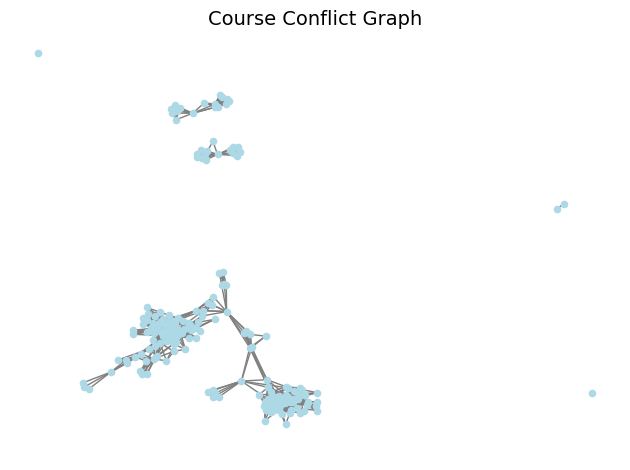

In [8]:
# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Layout algorithm
nx.draw_networkx(
    G,
    pos = pos,
    with_labels = False,
    node_size = 20,
    node_color = "lightblue",
    edge_color = "gray",
    font_size = 8,
    font_weight = "bold",
)

plt.title("Course Conflict Graph", fontsize=14)
plt.axis("off")  # Hide axes
plt.tight_layout()
plt.show()

In [ ]:
print("Graph created with", len(G.nodes), "courses and", len(G.edges), "conflicts.")

In [ ]:
# Number of students per course
course_counts = df_clean.groupby("CRN")["StudentID"].nunique()
course_counts.name = "NumStudents"

print(course_counts)

In [ ]:
# Degree of each course in the graph (number of conflicts)
course_degrees = pd.Series(dict(G.degree()), name="Degree").sort_values(ascending = False)

print(course_degrees)

In [ ]:
# compare between strategies
def compare_coloring_strategies(G):
    strategies = [
        'largest_first',
        'smallest_last',
        'saturation_largest_first'
    ]
    
    results = {}

    for strategy in strategies:
        start_time = time.time()
        coloring = nx.coloring.greedy_color(G, strategy=strategy)
        end_time = time.time()
        num_colors = len(set(coloring.values()))
        elapsed_time = end_time - start_time
        results[strategy] = {
            "coloring": coloring,
            "num_colors": num_colors,
            "elapsed_time": elapsed_time
        }

    return results

In [ ]:
# Run and compare strategies
coloring_results = compare_coloring_strategies(G)

# Show comparison results
print("Coloring strategy comparison results:")
for strategy, result in coloring_results.items():
    print(f"Strategy: {strategy}")
    print(f"  Number of colors (time slots): {result['num_colors']}")
    print(f"  Elapsed time: {result['elapsed_time']:.4f} seconds\n")

# Pick the best (least number of slots)
best_strategy = min(coloring_results, key=lambda x: coloring_results[x]['num_colors'])
best_coloring = coloring_results[best_strategy]['coloring']

print(f"✅ Best strategy: {best_strategy} with {coloring_results[best_strategy]['num_colors']} slots")


In [ ]:
# Plot top 10 courses enrolled by students
course_counts.sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 Courses enrolled by Students')
plt.ylabel("Number of Students")
plt.xlabel("Course (CRN)")
plt.tight_layout()
plt.show()

In [ ]:
# Plot top 10 courses by degree
course_degrees.sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 Courses by Conflict Degree', color='orange')
plt.ylabel("Number of Conflicts")
plt.xlabel("Course (CRN)")
plt.tight_layout()
plt.show()

In [ ]:
# Apply graph coloring for scheduling (Greedy coloring)
coloring = nx.coloring.greedy_color(G, strategy='saturation_largest_first') # produce dictionary for time slots

print(coloring)

In [ ]:
# Invert the coloring dict: group courses by time slot
from collections import defaultdict

slot_courses = defaultdict(list)
for course, slot in coloring.items():
    slot_courses[slot].append(course)

In [ ]:
# Create final timetable dataframe
timetable = []
for slot, courses in slot_courses.items():
    for course in courses:
        name = df_clean[df_clean["CRN"] == course]["CourseName"].iloc[0]
        num_students = course_counts[course]
        timetable.append({
            "CourseName": name,
            "CRN": course,
            "ExamSlot": slot + 1,
            "NumStudents": num_students
        })

timetable_df = pd.DataFrame(timetable)
timetable_df = timetable_df.sort_values(by = "ExamSlot")

In [ ]:
# Export to Excel
output_file = "exams_timetable.xlsx"
timetable_df.to_excel(output_file, index=False)
print("Timetable saved to:", output_file, " successfully 🥲🥹")